In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import os
import time
import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, optimizers, layers, metrics, models, regularizers

warnings.filterwarnings("ignore")

In [2]:
# Create a function to plot smoothed metric and loss curves
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [3]:
df = pd.read_pickle("Data/df_final1.pkl")

In [4]:
df_nn_cat = df.copy()

In [5]:
X = df_nn_cat.loc[:, ["prev_date", "kg_ordered", "prod_group", "silo_nr", "kg_delivered",
                      "RU Geit", "RU Grond", "RU Kalv", "RU Melkv", "RU Vlvee", "Rundvee"]]

y = df_nn_cat["difference"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [8]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(np.asarray(y_train).reshape(-1,1))

X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(np.asarray(y_test).reshape(-1,1))

X_val = scaler.fit_transform(X_val)
y_val = scaler.fit_transform(np.asarray(y_val).reshape(-1,1))

In [9]:
model = Sequential()
model.add(layers.Dense(16, input_shape=(11,), activation="sigmoid", kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation="sigmoid", kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                192       
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [11]:
model.compile(optimizer="adagrad", loss='mean_squared_error', metrics=tf.keras.metrics.RootMeanSquaredError())
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), use_multiprocessing=True)

Epoch 1/15
13322/13322 [==============================] - 25s 2ms/step - loss: 5.2755 - root_mean_squared_error: 2.2961 - val_loss: 3.2033 - val_root_mean_squared_error: 1.7889
Epoch 2/15
13322/13322 [==============================] - 25s 2ms/step - loss: 4.4733 - root_mean_squared_error: 2.1143 - val_loss: 3.1974 - val_root_mean_squared_error: 1.7872
Epoch 3/15
13322/13322 [==============================] - 21s 2ms/step - loss: 4.2073 - root_mean_squared_error: 2.0504 - val_loss: 3.1947 - val_root_mean_squared_error: 1.7865
Epoch 4/15
13322/13322 [==============================] - 21s 2ms/step - loss: 4.0577 - root_mean_squared_error: 2.0136 - val_loss: 3.1934 - val_root_mean_squared_error: 1.7861
Epoch 5/15
13322/13322 [==============================] - 22s 2ms/step - loss: 3.9480 - root_mean_squared_error: 1.9861 - val_loss: 3.1933 - val_root_mean_squared_error: 1.7861
Epoch 6/15
13322/13322 [==============================] - 21s 2ms/step - loss: 3.8640 - root_mean_squared_error: 1.

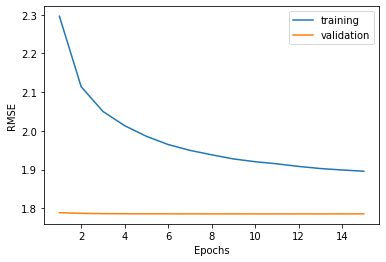

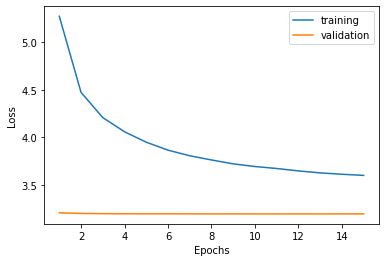

In [12]:
rmse_history = history.history["root_mean_squared_error"]
val_rmse_history = history.history["val_root_mean_squared_error"]

plt.plot(range(1, len(rmse_history) + 1), rmse_history)
plt.plot(range(1, len(val_rmse_history) + 1), val_rmse_history)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend(["training", "validation"])
plt.show()

loss_history = history.history["loss"]
val_loss_history = history.history["val_loss"]

plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.show()

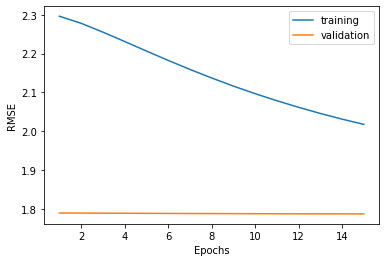

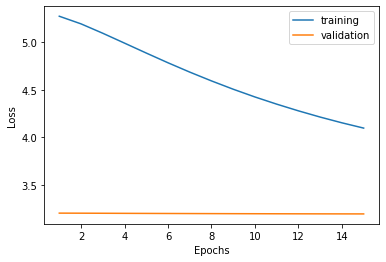

In [13]:
smooth_rmse_history = smooth_curve(rmse_history)
smooth_val_rmse_history = smooth_curve(val_rmse_history)

plt.plot(range(1, len(smooth_rmse_history) + 1), smooth_rmse_history)
plt.plot(range(1, len(smooth_val_rmse_history) + 1), smooth_val_rmse_history)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend(["training", "validation"])
plt.show()

smooth_loss_history = smooth_curve(loss_history)
smooth_val_loss_history = smooth_curve(val_loss_history)

plt.plot(range(1, len(smooth_loss_history) + 1), smooth_loss_history)
plt.plot(range(1, len(smooth_val_loss_history) + 1), smooth_val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.show()

In [14]:
model.evaluate(X_val, y_val)

2351/2351 [==============================] - 1s 559us/step - loss: 3.1922 - root_mean_squared_error: 1.7858


In [16]:
model.evaluate(X_test, y_test)

1742/1742 [==============================] - 1s 669us/step - loss: 3.3869 - root_mean_squared_error: 1.8395


In [18]:
val_pred = model.predict(X_val).ravel()
test_pred = model.predict(X_test).ravel()

In [20]:
inv_val_pred = scaler.inverse_transform(val_pred.reshape(-1, 1))
inv_y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

inv_test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1))
inv_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_val = mean_squared_error(inv_y_val, inv_val_pred)
mse_test = mean_squared_error(inv_y_test, inv_test_pred)

print("RMSE on validation set:", np.sqrt(mse_val))
print("RMSE on test set:", np.sqrt(mse_test))

RMSE on validation set: 21.429184
RMSE on test set: 22.073732


In [21]:
percentages = []

for idx, val in enumerate(inv_test_pred):
    perc = np.abs(val-inv_y_test[idx])/inv_y_test[idx]
    percentages.append(perc[0])

In [22]:
print(f"Minimum percent error: {np.round(np.min(percentages),2)}")
print(f"Maximum percent error: {np.round(np.max(percentages),2)}")
print(f"Mean percent error: {np.round(np.mean(percentages),2)}")

Minimum percent error: 0.0
Maximum percent error: 21.139999389648438
Mean percent error: 1.0399999618530273


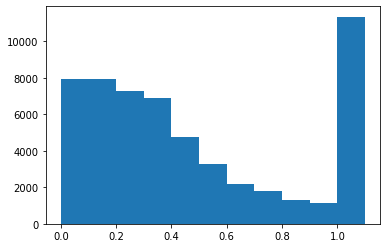

In [23]:
percentages = np.asarray(percentages)

plt.hist(percentages.clip(min=0, max=1.1), range=[0,1.1], bins=11)
plt.show()

In [24]:
lower = []

for i in percentages:
    if i <= 0.5:
        lower.append(i)

print(f"Number of orders with a percent error lower than 0.5: {len(lower)}")
print(f"Percentage of orders with a percent error lower than 0.5: {np.round(len(lower)/len(percentages),2)}")

Number of orders with a percent error lower than 0.5: 34770
Percentage of orders with a percent error lower than 0.5: 0.62


In [25]:
differences = []

for idx, val in enumerate(inv_y_test):
    differences.append(np.abs(val[0]-inv_test_pred[idx][0]))

In [26]:
within_1 = [1 if np.round(diff) <= 1 else 0 for diff in differences]
within_3 = [1 if np.round(diff) <= 3 else 0 for diff in differences]
within_5 = [1 if np.round(diff) <= 5 else 0 for diff in differences]
within_7 = [1 if np.round(diff) <= 7 else 0 for diff in differences]

In [27]:
print(f"Percentage of orders predicted correctly within 1 day: {np.round(np.sum(within_1)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 3 days: {np.round(np.sum(within_3)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 5 days: {np.round(np.sum(within_5)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 7 days: {np.round(np.sum(within_7)/len(differences),2)}")

Percentage of orders predicted correctly within 1 day: 0.12
Percentage of orders predicted correctly within 3 days: 0.28
Percentage of orders predicted correctly within 5 days: 0.44
Percentage of orders predicted correctly within 7 days: 0.57
